### T009_Ligand-based pharmacophores

In [1]:
import collections
from collections import Counter
from pathlib import Path
import operator
import time
import math

import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets, cluster

from rdkit import RDConfig, Chem, Geometry, DistanceGeometry
from rdkit.Chem import (
    ChemicalFeatures,
    rdDistGeom,
    Draw,
    rdMolTransforms,
    AllChem,
)
from rdkit.Chem.Draw import DrawingOptions
from rdkit.Chem.Pharm3D import Pharmacophore, EmbedLib
from rdkit.Numerics import rdAlignment
import nglview as nv


In [2]:
# Set the Path to the current notebook
HERE = Path(_dh[-1])
DATA = HERE / "data"

### Get pre-aligned ligands from previous talktorial

In [3]:
# Get the file paths to all ligand PDB files
mol_files = sorted(Path(HERE / "../T000_template/data/").glob("*_lig.pdb"))
print([f.name for f in mol_files])

pdb_ids = [Path(file).stem.split("_")[0] for file in mol_files]
pdb_ids.pop(0)
pdb_ids

['4WMU_lig.pdb', '5FC4_lig.pdb', '6OQB_lig.pdb', '6OQD_lig.pdb', '6UDT_lig.pdb', '6UDV_lig.pdb']


['5FC4', '6OQB', '6OQD', '6UDT', '6UDV']

CC1CCC2C(C1)NC(C(O)NS(C)(O)O)C2CCCOC1CCCC2CCCCC21.CC1CCC2C(C1)NC(C(O)NS(C)(O)O)C2CCCOC1CCCC2CCCCC21
/home/jovyan/teachopencadd/teachopencadd/talktorials/T000_template/../T000_template/data/6OQB_lig.pdb Could not be read
CC1CCC2C(CCCC23COC2CCC4CC2N(CC2CCC2C(O)CCCCC(C)S(O)(O)NC4O)C3)C1
CC1CCC2C(CCCC23COC2CCC4CC2N(CC2CCC2C(O)CCCCN(C)C(O)CC4(O)C(O)O)C3)C1
CC1CCC2C(CCCC23COC2CCC4CC2N(CC2CCC2C(O)CCCC(C)C(C)S(O)(O)NC4O)C3)C1
Number of molecules: 4


[18:48:29] Cannot determine element for PDB atom #42


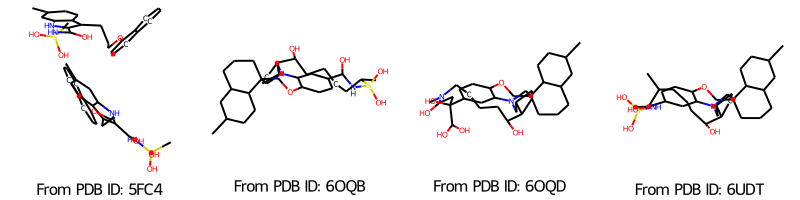

In [4]:
# Read all ligands from these PDB files using RDKit
molecules = []
for mol_file in mol_files[1:]:
    molecule = Chem.MolFromPDBFile(str(mol_file), removeHs=False)
    if molecule is None:
        print(mol_file, "Could not be read")
    else:
        Chem.SanitizeMol(molecule)
        print(Chem.MolToSmiles(molecule))
        molecules.append(molecule)
print(f"Number of molecules: {len(molecules)}")

Draw.MolsToGridImage(
    molecules,
    molsPerRow=4,
    legends=[f"From PDB ID: {pdb_id}" for pdb_id in pdb_ids],
)

### Keep the original coordinate and make a copy for the 2D representation

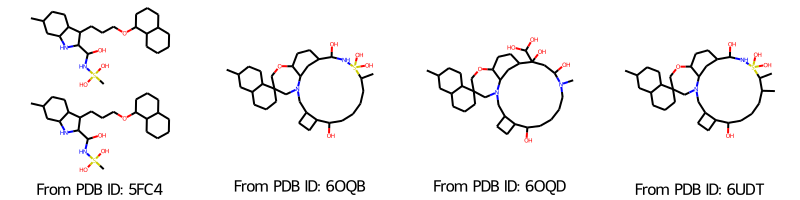

In [5]:
molecules_2d = []
for molecule in molecules:
    tmp = Chem.Mol(molecule)
    AllChem.Compute2DCoords(tmp)
    molecules_2d.append(tmp)
Draw.MolsToGridImage(
    molecules_2d,
    molsPerRow=4,
    legends=[f"From PDB ID: {pdb_id}" for pdb_id in pdb_ids],
)

### Define a function “show_ligands” to visualize the ligand molecules

In [6]:
def show_ligands(molecules):
    """Generate a view of the ligand molecules.

    Parameters
    -----------
    molecules: list of rdkit.Chem.rdchem.Mol

    Returns
    ----------
    nglview.widget.NGLWidget
    """
    view = nv.NGLWidget()
    for molecule in molecules:
        component = view.add_component(molecule)
        time.sleep(0.1)
        component.clear()
        component.add_ball_and_stick(multipleBond=True)
    return view

view = show_ligands(molecules)
view

view.render_image(trim=True, factor=2, transparent=True);

view._display_image()

### Extract pharmacophore features

In [7]:
# Load a feature factory to extract pharmacophore features per ligand
feature_factory = AllChem.BuildFeatureFactory(str(Path(RDConfig.RDDataDir) / "BaseFeatures.fdef"))

# Look at the pharmacophore features that are implemented in RDKit
list(feature_factory.GetFeatureDefs().keys())

['Donor.SingleAtomDonor',
 'Acceptor.SingleAtomAcceptor',
 'NegIonizable.AcidicGroup',
 'PosIonizable.BasicGroup',
 'PosIonizable.PosN',
 'PosIonizable.Imidazole',
 'PosIonizable.Guanidine',
 'ZnBinder.ZnBinder1',
 'ZnBinder.ZnBinder2',
 'ZnBinder.ZnBinder3',
 'ZnBinder.ZnBinder4',
 'ZnBinder.ZnBinder5',
 'ZnBinder.ZnBinder6',
 'Aromatic.Arom4',
 'Aromatic.Arom5',
 'Aromatic.Arom6',
 'Aromatic.Arom7',
 'Aromatic.Arom8',
 'Hydrophobe.ThreeWayAttach',
 'Hydrophobe.ChainTwoWayAttach',
 'LumpedHydrophobe.Nitro2',
 'LumpedHydrophobe.RH6_6',
 'LumpedHydrophobe.RH5_5',
 'LumpedHydrophobe.RH4_4',
 'LumpedHydrophobe.RH3_3',
 'LumpedHydrophobe.tButyl',
 'LumpedHydrophobe.iPropyl']

In [8]:
molecule_feature_frequencies = []
for molecule in molecules:
    features = [feature.GetFamily() for feature in feature_factory.GetFeaturesForMol(molecule)]
    feature_frequency = collections.Counter(features)
    molecule_feature_frequencies.append(feature_frequency)

feature_frequencies_df = (
    pd.DataFrame(
        molecule_feature_frequencies,
        index=[f"Mol{i}" for i, _ in enumerate(molecules, 1)],
    )
    .fillna(0)
    .astype(int)
)
feature_frequencies_df.transpose()

,Mol1,Mol2,Mol3,Mol4
Donor,10,6,7,6
Acceptor,8,5,6,5
PosIonizable,2,1,2,1
Hydrophobe,14,8,7,9
LumpedHydrophobe,2,3,3,3


### Concentrate on the following feature types: hydrogen bond acceptors (acceptors), hydrogen bond donors (donors), and hydrophobic contacts (hydrophobics)

In [9]:
# Retrieve the feature RDKit objects per feature type and per molecule
acceptors = []
donors = []
hydrophobics = []

for molecule in molecules:
    acceptors.append(feature_factory.GetFeaturesForMol(molecule, includeOnly="Acceptor"))
    donors.append(feature_factory.GetFeaturesForMol(molecule, includeOnly="Donor"))
    hydrophobics.append(feature_factory.GetFeaturesForMol(molecule, includeOnly="Hydrophobe"))

features = {
    "donors": donors,
    "acceptors": acceptors,
    "hydrophobics": hydrophobics,
}

### Show the pharmacophore features of all ligands

In [10]:
feature_colors = {
    "donors": (0, 0.9, 0),  # Green
    "acceptors": (0.9, 0, 0),  # Red
    "hydrophobics": (1, 0.9, 0),  # Yellow
}

### Define a function "visualize_features" to visualize the features for the feature types

In [11]:
def visualize_features(
    molecules,
    features,
    feature_type="features",
    color="yellow",
    sphere_radius=0.5,
):
    """Generate a view of the molecules highlighting the specified feature type.

    Parameters
    -----------
    molecules: list of rdkit.Chem.rdchem.Mol
        molecules to be visualized
    features: list of tuples of rdkit.Chem.rdMolChemicalFeatures.MolChemicalFeature
        extracted features from molecules chosen to be highlighted
    feature_type: string, optional
        name of the feature to be highlighted
    color: string, optional
        color used to display the highlighted features
    sphere_radius: float, optional
        display size of the highlighted features

    Returns
    ----------
    nglview.widget.NGLWidget
    """
    print(f"Number of {feature_type} in all ligands: {sum([len(i) for i in features])}")
    view = show_ligands(molecules)
    for i, feature_set in enumerate(features, 1):
        for feature in feature_set:
            loc = list(feature.GetPos())
            label = f"{feature_type}_{i}"
            view.shape.add_sphere(loc, color, sphere_radius, label)
    return view

In [12]:
feature_type = "donors"
view = visualize_features(
    molecules,
    features[feature_type],
    feature_type,
    feature_colors[feature_type],
)
view

Number of donors in all ligands: 29


NGLWidget()

In [13]:
view.render_image(trim=True, factor=2, transparent=True);
view._display_image()

### Visualize hydrogen bond acceptors

In [14]:
feature_type = "acceptors"
view = visualize_features(
    molecules,
    features[feature_type],
    feature_type,
    feature_colors[feature_type],
)
view

Number of acceptors in all ligands: 24


NGLWidget()

In [15]:
view.render_image(trim=True, factor=2, transparent=True);
view._display_image()

### Visualize hydrophobic contacts

In [16]:
feature_type = "hydrophobics"
view = visualize_features(
    molecules,
    features[feature_type],
    feature_type,
    feature_colors[feature_type],
)
view

Number of hydrophobics in all ligands: 38


NGLWidget()

In [17]:
view.render_image(trim=True, factor=2, transparent=True);
view._display_image()

### Collect coordinates of features per feature type

In [18]:
features_coord = {
    "donors": [list(item.GetPos()) for sublist in features["donors"] for item in sublist],
    "acceptors": [list(item.GetPos()) for sublist in features["acceptors"] for item in sublist],
    "hydrophobics": [
        list(item.GetPos()) for sublist in features["hydrophobics"] for item in sublist
    ],
}

In [19]:
features_coord["acceptors"]

[[1.229, 1.523, 5.943],
 [-0.619, 3.112, 5.675],
 [3.03, 2.91, 7.911],
 [5.753, 2.836, 13.011],
 [8.157, -6.08, 22.74],
 [8.007, -7.171, 20.53],
 [6.979, -5.047, 18.712],
 [3.774, -2.756, 14.492],
 [15.213, -3.768, 11.399],
 [15.35, -0.447, 19.508],
 [22.104, -2.182, 15.943],
 [21.958, -4.575, 16.475],
 [19.186, -1.307, 15.729],
 [6.563, 3.922, 96.196],
 [7.64, 0.104, 104.093],
 [0.899, 1.597, 102.024],
 [3.548, 0.272, 100.976],
 [2.232, -0.056, 99.217],
 [1.327, 2.512, 99.474],
 [6.377, 3.787, 96.45],
 [7.005, 0.357, 104.634],
 [0.79, 0.591, 102.364],
 [0.281, 2.984, 102.042],
 [1.13, 2.042, 99.564]]

### Use k-means clustering to cluster features per feature type

In [20]:
kq = 7
min_cluster_size = int(len(molecules) * 0.75)
top_cluster_number = 4

In [21]:
def clustering(feature_coord, kq):
    """
    Compute the k-means clustering of input feature coordinates.

    Parameters
    -----------
    feature_coord: list
        feature coordinates extracted from the features of a set of molecules
    kq: int
        Quotient used when calculating number of features k

    Returns
    ----------
    sklearn.cluster._kmeans.KMeans
    """
    # Define parameter k as feature number divided by "k quotient"
    k = math.ceil(len(feature_coord) / kq)
    # Tailor-made adaption of k for hydrophobics in for the example in this talktorial
    k = 2 if k == 1 else k
    print(f"Clustering: \nVariable k in k-means: {k} of {len(feature_coord)} points\n")

    # Initialize k-means and compute clustering
    k_means = cluster.KMeans(n_clusters=k)
    k_means.fit(feature_coord)

    return k_means

In [22]:
def get_clusters(k_means, min_cluster_size, top_cluster_number):
    """
    Select clusters from a k-means clustering and returns the indices of the selected clusters.
    The selection is based on cluster size. The largest clusters are chosen.

    Parameters
    -----------
    k_means: sklearn.cluster._kmeans.KMeans
        k-means clustering of feature coordinates
    min_cluster_size: int
        minimum size needed for a cluster to be viable for selection
    top_cluster_number: int
        number of clusters to be selected

    Returns
    ----------
    list of int
        indices of selected clusters
    """

    # Sort clusters by size and only show largest
    feature_labels = k_means.labels_

    feature_labels_count = Counter(feature_labels)

    feature_labels_count = sorted(
        feature_labels_count.items(), key=operator.itemgetter(1), reverse=True
    )
    print(f"Clusters sorted by size: \n{feature_labels_count}\n")

    # Get number of the largest clusters, which are larger then the threshold (selected clusters)
    cluster_indices_sel = []

    for cluster_index, cluster_size in feature_labels_count:
        if cluster_size >= min_cluster_size and top_cluster_number > 0:
            cluster_indices_sel.append(cluster_index)
            top_cluster_number -= 1

    print(f"Cluster indices of selected clusters: \n{cluster_indices_sel}\n")

    return cluster_indices_sel


In [23]:
k_means = {
    "donors": clustering(features_coord["donors"], kq),
    "acceptors": clustering(features_coord["acceptors"], kq),
    "hydrophobics": clustering(features_coord["hydrophobics"], kq),
}

Clustering: 
Variable k in k-means: 5 of 29 points

Clustering: 
Variable k in k-means: 4 of 24 points

Clustering: 
Variable k in k-means: 6 of 38 points



In [ ]:
### Select relevant clusters

In [24]:
print("Hydrogen bond donors\n")
cluster_indices_sel_donors = get_clusters(k_means["donors"], min_cluster_size, top_cluster_number)

Hydrogen bond donors

Clusters sorted by size: 
[(0, 9), (1, 6), (2, 5), (3, 5), (4, 4)]

Cluster indices of selected clusters: 
[0, 1, 2, 3]



In [25]:
print("Hydrogen bond acceptors\n")
cluster_indices_sel_acceptors = get_clusters(
    k_means["acceptors"], min_cluster_size, top_cluster_number
)

Hydrogen bond acceptors

Clusters sorted by size: 
[(0, 11), (1, 5), (2, 4), (3, 4)]

Cluster indices of selected clusters: 
[0, 1, 2, 3]



In [26]:
print("Hydrophobic contacts\n")
cluster_indices_sel_hydrophobic = get_clusters(
    k_means["hydrophobics"], min_cluster_size, top_cluster_number
)

Hydrophobic contacts

Clusters sorted by size: 
[(1, 9), (0, 8), (4, 8), (3, 5), (2, 4), (5, 4)]

Cluster indices of selected clusters: 
[1, 0, 4, 3]



In [27]:
cluster_indices_sel = {
    "donors": cluster_indices_sel_donors,
    "acceptors": cluster_indices_sel_acceptors,
    "hydrophobics": cluster_indices_sel_hydrophobic,
}

In [ ]:
### Define a function "get_selected_cluster_center_coords" to get selected cluster coordinates

In [28]:
def get_selected_cluster_center_coords(k_means, cluster_indices_sel):
    """Retrieve cluster center coordinates for selected clusters.
    The selected clusters are defined by their indices.

    Parameters
    -----------
    k_means: sklearn.cluster._kmeans.KMeans
        k-means clustering of feature coordinates
    cluster_indices_sel: list of int
        indices of the chosen clusters

    Returns
    ----------
    two-dimensional list of floats
        cluster center coordinates
    """
    cluster_centers = k_means.cluster_centers_

    # Cast to list and then to pandas Series (for element selection by indices)
    cluster_centers = pd.Series(cluster_centers.tolist())

    # Select cluster centers by indices of selected clusters
    cluster_centers_sel = cluster_centers[cluster_indices_sel]

    return list(cluster_centers_sel)

In [29]:
cluster_centers_sel = {
    "donors": get_selected_cluster_center_coords(k_means["donors"], cluster_indices_sel["donors"]),
    "acceptors": get_selected_cluster_center_coords(
        k_means["acceptors"], cluster_indices_sel["acceptors"]
    ),
    "hydrophobics": get_selected_cluster_center_coords(
        k_means["hydrophobics"], cluster_indices_sel["hydrophobics"]
    ),
}

In [30]:
cluster_centers_sel["acceptors"]

[[3.4356363636363634, 1.6465454545454548, 100.63945454545454],
 [18.7622, -2.4558, 15.810799999999993],
 [2.34825, 2.59525, 8.134999999999998],
 [6.72925, -5.2635, 19.118499999999997]]

In [ ]:
### Define a fucntion "visualize_clusters" to visualize cluster centers alongside with all molecules and all feature points

In [31]:
def visualize_clusters(
    molecules,
    features,
    clusters,
    feature_type="features",
    color="yellow",
    feature_radius=0.5,
    cluster_radius=1,
):
    """Visualize the cluster centers.

    Parameters
    -----------
     molecules: list of rdkit.Chem.rdchem.Mol
        molecules to be visualized
    features: list of tuples of rdkit.Chem.rdMolChemicalFeatures.MolChemicalFeature
        extracted features from molecules chosen to be highlighted
    clusters: Two-dimensional list of floats
        cluster center coordinates
    feature_type: string, optional
        feature type being visualized
    color: string, optional
        color used for rendering the features and cluster centers
    feature_radius: float, optional
        rendering size of the features
    cluster_radius: float, optional
        rendering size of the cluster centers

    Returns
    ----------
    nglview.widget.NGLWidget
    """
    view = visualize_features(
        molecules,
        features,
        feature_type,
        color=color,
        sphere_radius=feature_radius,
    )
    for i, center in enumerate(clusters, 1):
        view.shape.add_sphere(list(center), color, cluster_radius, f"cluster_{feature_type}_{i}")
    return view


In [ ]:
### Hydrogen bond donors

In [32]:
feature_type = "donors"
view = visualize_clusters(
    molecules,
    features[feature_type],
    cluster_centers_sel[feature_type],
    feature_type,
    feature_colors[feature_type],
)
view

Number of donors in all ligands: 29


NGLWidget()

In [33]:
view.render_image(trim=True, factor=2, transparent=True)

view._display_image()

In [ ]:
### Hydrogen bond acceptor

In [34]:
feature_type = "acceptors"
view = visualize_clusters(
    molecules,
    features[feature_type],
    cluster_centers_sel[feature_type],
    feature_type,
    feature_colors[feature_type],
)
view

Number of acceptors in all ligands: 24


NGLWidget()

In [35]:
view.render_image(trim=True, factor=2, transparent=True)
view._display_image()

In [ ]:
### Hydrophobic contacts

In [36]:
feature_type = "hydrophobics"
view = visualize_clusters(
    molecules,
    features[feature_type],
    cluster_centers_sel[feature_type],
    feature_type,
    feature_colors[feature_type],
)
view

Number of hydrophobics in all ligands: 38


NGLWidget()

In [37]:
view.render_image(trim=True, factor=2, transparent=True)
view._display_image()

In [ ]:
### Show ensemble pharmacophore

In [38]:
view = show_ligands(molecules)
# Load clusters
for feature_type in cluster_indices_sel.keys():
    centers = cluster_centers_sel[feature_type]
    for i, loc in enumerate(centers):
        sphere_radius = 1
        feature_color = feature_colors[feature_type]
        label = f"{feature_type}_c{i}"
        view.shape.add_sphere(loc, feature_color, sphere_radius, label)
view

NGLWidget()

In [39]:
view.render_image(trim=True, factor=2, transparent=True)
view._display_image()